In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch

import osmnx as ox
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
import geopandas
from geopandas.tools import sjoin
from pyproj import Proj, transform
from geopy.distance import distance
from shapely.geometry import LineString, Point, LinearRing


from dask import dataframe
import multiprocessing
from tqdm import tqdm
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

/work/sagarj/miniconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/work/sagarj/miniconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
gpd.__version__

'0.6.1'

In [3]:
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [4]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('../Data/Geo_Data/geo/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

{}
(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)
[-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894]
0.8443906332745678 0.4051139537590416


In [5]:
roads = gpd.read_file('data/London_roads_sanja/edges.shp')

In [6]:
# len(roads)

In [7]:
roads = roads.to_crs({'init': 'epsg:32630'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
roads.crs

{'init': 'epsg:32630'}

In [9]:
m25_choice = gpd.read_file('data/M25/M25_seg_p.shp')

In [10]:
m25_choice = m25_choice.to_crs({'init': 'epsg:32630'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
joined_roads = sjoin(roads,m25_choice,how='inner')

In [12]:
len(joined_roads),len(m25_choice),len(roads)

(189593, 280715, 161645)

In [13]:
# joined_roads.iloc[20]['geometry']

In [14]:
joined_roads['geometry'] = joined_roads['geometry'].buffer(10)

In [15]:
# joined_roads.iloc[200]['geometry']

In [16]:
joined_roads = joined_roads.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
print(joined_roads.columns)

Index(['u', 'v', 'key', 'osmid', 'name', 'highway', 'access', 'oneway',
       'length', 'from', 'to', 'maxspeed', 'lanes', 'ref', 'bridge',
       'junction', 'tunnel', 'width', 'est_width', 'service', 'area',
       'geometry', 'index_right', 'ID', 'AID', 'Degree', 'IntR2k', 'IntR800',
       'IntRN', 'LogChR2k', 'LogChR800', 'LogChRN', 'NCR2k', 'NCR800',
       'segLen'],
      dtype='object')


In [18]:
roads_WGS84 = joined_roads[['osmid','geometry','LogChR800','area']].copy()

In [19]:
roads_WGS84.head(n=5)

,osmid,geometry,LogChR800,area
4,204647020,"POLYGON ((-0.15275 51.52352, -0.15277 51.52352...",3.905958,None
5,233623258,"POLYGON ((-0.15308 51.52393, -0.15308 51.52394...",3.905958,None
157171,19796012,"POLYGON ((-0.15806 51.52468, -0.15802 51.52466...",3.905958,None
4,204647020,"POLYGON ((-0.15275 51.52352, -0.15277 51.52352...",3.030195,None
4464,292570593,"POLYGON ((-0.14955 51.52470, -0.14954 51.52470...",3.030195,None


In [20]:
from geopandas.tools import sjoin

In [21]:
stephen_data = 'scratchpad/GLa_tree_loc.csv'
Stephen_data = pd.read_csv(stephen_data)

In [22]:
trees_dict = {'id':[], 'geometry':[] , 'treePercent':[]}
for index,row in Stephen_data.iterrows():
    trees_dict['id'].append(row['GLA_ID'])
    trees_dict['geometry'].append(Point(row['lon'],row['lat']))
    trees_dict['treePercent'].append(row['treePercen'])
Stephen_trees = pd.DataFrame.from_dict(trees_dict)
stephen_trees_gdf = gpd.GeoDataFrame(Stephen_trees, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [23]:
len(roads_WGS84), len(stephen_trees_gdf)

(189593, 104777)

In [24]:
joined_GSV_trees = sjoin(roads_WGS84 , stephen_trees_gdf,how='left')

In [84]:
joined_GSV_trees.head(n=5)

,osmid,geometry,LogChR800,area,index_right,id,treePercent,road_centroid,choice,choice_scaled
5,233623258,"POLYGON ((-0.15308 51.52393, -0.15308 51.52394...",3.905958,None,93239.0,36005.0,0.086071,POINT (-0.15287 51.52381),49.697653,30.238095
157171,19796012,"POLYGON ((-0.15806 51.52468, -0.15802 51.52466...",3.905958,None,49788.0,38417.0,0.064196,POINT (-0.15563 51.52397),49.697653,30.238095
157171,19796012,"POLYGON ((-0.15806 51.52468, -0.15802 51.52466...",3.905958,None,59511.0,38415.0,0.080093,POINT (-0.15563 51.52397),49.697653,30.238095
157171,19796012,"POLYGON ((-0.15806 51.52468, -0.15802 51.52466...",3.905958,None,74706.0,38416.0,0.068015,POINT (-0.15563 51.52397),49.697653,30.238095
4464,292570593,"POLYGON ((-0.14955 51.52470, -0.14954 51.52470...",3.030195,None,22306.0,30283.0,0.175527,POINT (-0.15122 51.52432),20.701265,12.102402


In [25]:
joined_GSV_trees = joined_GSV_trees[joined_GSV_trees['osmid'].notna()]
joined_GSV_trees = joined_GSV_trees[joined_GSV_trees['treePercent'].notna()]

joined_GSV_trees['road_centroid'] = joined_GSV_trees['geometry'].centroid
joined_GSV_trees['choice'] = joined_GSV_trees['LogChR800'].apply(lambda x : np.exp(x))
min_choice = min(joined_GSV_trees['choice'])
max_choice = max(joined_GSV_trees['choice'])

joined_GSV_trees['choice_scaled'] = joined_GSV_trees['choice'].apply(lambda x:((x - min_choice)/(max_choice-min_choice))*100.0)

In [138]:
len(joined_GSV_trees['osmid'].unique()), len(joined_GSV_trees)

(49486, 188619)

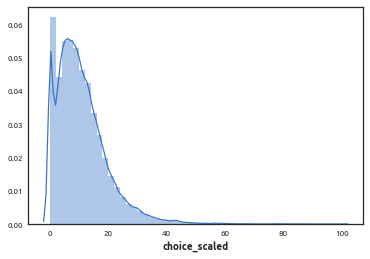

In [85]:
sns.distplot(joined_GSV_trees['choice_scaled'])

In [86]:
road_aggregated = {'osmid':[] , 'geometry' : [], 'green_sat':[] , 'choice':[] }
for name , group in joined_GSV_trees.groupby('osmid'):
    road_aggregated['osmid'].append(name)
    road_aggregated['geometry'].append(group.iloc[0]['road_centroid'])
    road_aggregated['green_sat'].append(np.mean(group['treePercent']))
    road_aggregated['choice'].append(group.iloc[0]['choice_scaled'])
road_aggregated_df = pd.DataFrame.from_dict(road_aggregated)
road_aggregated_gpd = gpd.GeoDataFrame(road_aggregated_df, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [87]:
wards_shape = gpd.read_file('../Data/Geo_Data/wards_london_2016/London-wards-2018_ESRI/London_Ward.shp')

In [88]:
wards_shape = wards_shape.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


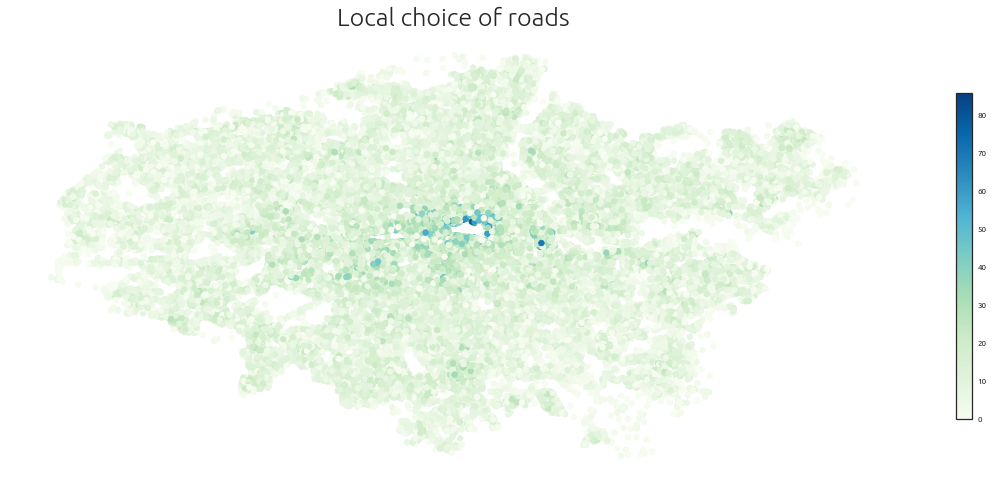

In [112]:
# road_aggregated_gpd.head(n=5)
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Local choice of roads', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_aggregated_gpd['choice'].min(), vmax=road_aggregated_gpd['choice'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_aggregated_gpd.plot(ax=ax,column='choice', cmap='GnBu', linewidth=0.8)

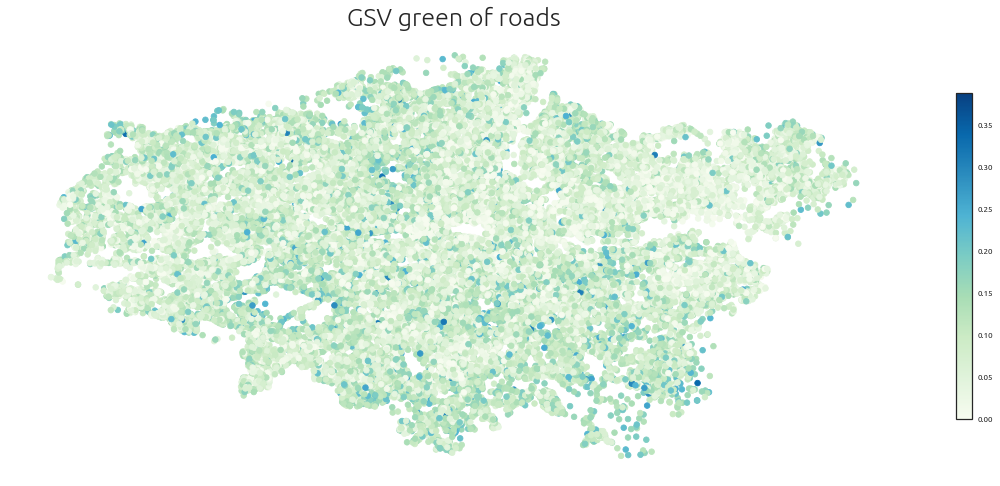

In [114]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('GSV green of roads', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_aggregated_gpd['green_sat'].min(), vmax=road_aggregated_gpd['green_sat'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_aggregated_gpd.plot(ax=ax,column='green_sat', cmap='GnBu', linewidth=0.8)

In [89]:
wards_shape.head(n=5)

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.0,"POLYGON ((-0.28409 51.36515, -0.28473 51.36541..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.0,"POLYGON ((-0.30385 51.39249, -0.30375 51.39252..."
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.506,0.0,"POLYGON ((-0.27257 51.37227, -0.27263 51.37228..."
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.821,0.0,"POLYGON ((-0.25873 51.40956, -0.25869 51.40955..."


In [90]:
joined_road_wards = sjoin(wards_shape,road_aggregated_gpd,how='left')

joined_road_wards= joined_road_wards[joined_road_wards['choice'].notna()]

In [147]:
joined_road_wards.head(n=5)

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry,index_right,osmid,green_sat,choice
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",8978.0,224801816,0.010506,6.234498
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",10440.0,23054564,0.027564,5.852661
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",10441.0,23054611,0.034575,9.433333
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",34475.0,69146059,0.049627,3.209832
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",41287.0,"[175872776, 220771987, 2953612]",0.118918,0.926856


In [ ]:
sns.distplot(joined_road_wards['choice'])

In [102]:
gsv_ward_aggregated = {'GSS_CODE':[] , 'NAME' : [], 'geometry':[] , 'green_gsv':[] }
for name , group in joined_road_wards.groupby('GSS_CODE'):
    gsv_ward_aggregated['GSS_CODE'].append(name)
    gsv_ward_aggregated['geometry'].append(group.iloc[0]['geometry'])
    numerator = sum(group['green_sat']*group['choice']*100.0)
    denom = sum(group['choice'])
    gsv_ward_aggregated['green_gsv'].append(numerator/denom)
    gsv_ward_aggregated['NAME'].append(group.iloc[0]['NAME'])
gsv_ward_aggregated_df = pd.DataFrame.from_dict(gsv_ward_aggregated)
gsv_ward_aggregated_gpd = gpd.GeoDataFrame(gsv_ward_aggregated_df, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [103]:
gsv_ward_aggregated_gpd.head(n=5)

,GSS_CODE,NAME,geometry,green_gsv
0,E05000026,Abbey,"POLYGON ((0.08548 51.53704, 0.08535 51.53693, ...",3.976812
1,E05000027,Alibon,"POLYGON ((0.13190 51.54376, 0.13208 51.54383, ...",3.877607
2,E05000028,Becontree,"POLYGON ((0.10743 51.55200, 0.10757 51.55204, ...",4.076038
3,E05000029,Chadwell Heath,"POLYGON ((0.14698 51.57568, 0.14654 51.57566, ...",6.398663
4,E05000030,Eastbrook,"POLYGON ((0.16157 51.54333, 0.16156 51.54378, ...",3.519222


In [106]:
gsv_ward_aggregated_reproj = gsv_ward_aggregated_gpd.to_crs({'init': 'epsg:27700'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


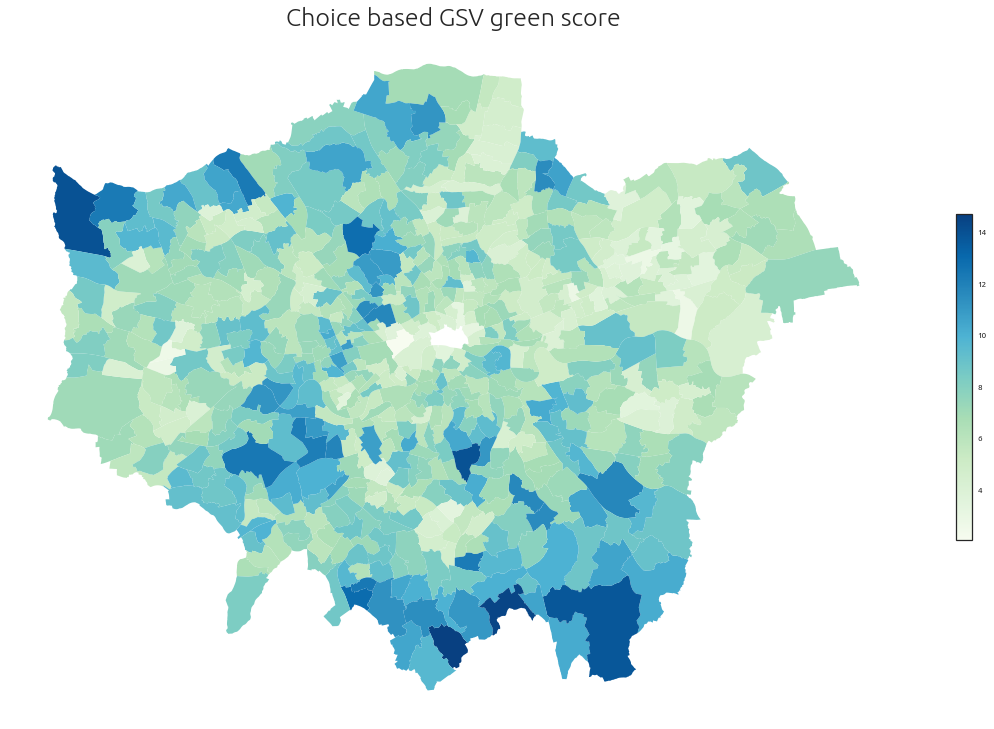

In [107]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Choice based GSV green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=gsv_ward_aggregated_reproj['green_gsv'].min(), vmax=gsv_ward_aggregated_gpd['green_gsv'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
gsv_ward_aggregated_reproj.plot(ax=ax,column='green_gsv', cmap='GnBu', linewidth=0.8)

In [108]:
len(joined_road_wards)

49483

In [116]:
satellite_green = pd.read_csv('scratchpad/SAT_greenery_per_segment.csv')

In [117]:
satellite_green.head()

,Unnamed: 0,osmid,sat_green_area,sat_green_pct,segment_tot_area
0,0,100076118,90.917383,0.043730,2079.067103
1,1,100076137,1870.298240,0.313623,5963.514822
2,2,100076140,7846.994381,0.393731,19929.850956
3,3,100076150,28.874368,0.046160,625.533164
4,4,100076152,793.291016,0.122778,6461.192078


In [118]:
len(satellite_green)

98868

In [126]:
joined_SAT_trees = pd.merge(roads_WGS84 , satellite_green,left_on='osmid' , right_on='osmid', how='inner')

In [127]:
len(joined_SAT_trees)

187202

In [130]:
joined_SAT_trees.head(n=5)

,osmid,geometry,LogChR800,area,Unnamed: 0,sat_green_area,sat_green_pct,segment_tot_area
0,204647020,"POLYGON ((-0.15275 51.52352, -0.15277 51.52352...",3.905958,None,16731,19.649376,0.041350,475.195801
1,204647020,"POLYGON ((-0.15275 51.52352, -0.15277 51.52352...",3.030195,None,16731,19.649376,0.041350,475.195801
2,233623258,"POLYGON ((-0.15308 51.52393, -0.15308 51.52394...",3.905958,None,23839,47.116444,0.037721,1249.079411
3,19796012,"POLYGON ((-0.15806 51.52468, -0.15802 51.52466...",3.905958,None,15777,1926.383081,0.230323,8363.849381
4,19796012,"POLYGON ((-0.15806 51.52468, -0.15802 51.52466...",3.015779,None,15777,1926.383081,0.230323,8363.849381


In [132]:
joined_SAT_trees = joined_SAT_trees.drop_duplicates(subset=['osmid'])
len(joined_SAT_trees)

75906

In [134]:
joined_SAT_trees.head(n=5)

,osmid,geometry,LogChR800,area,Unnamed: 0,sat_green_area,sat_green_pct,segment_tot_area
0,204647020,"POLYGON ((-0.15275 51.52352, -0.15277 51.52352...",3.905958,None,16731,19.649376,0.041350,475.195801
2,233623258,"POLYGON ((-0.15308 51.52393, -0.15308 51.52394...",3.905958,None,23839,47.116444,0.037721,1249.079411
3,19796012,"POLYGON ((-0.15806 51.52468, -0.15802 51.52466...",3.905958,None,15777,1926.383081,0.230323,8363.849381
6,292570593,"POLYGON ((-0.14955 51.52470, -0.14954 51.52470...",3.030195,None,31854,2487.382010,0.476548,5219.587666
8,204647015,"POLYGON ((-0.15274 51.52404, -0.15273 51.52403...",3.030195,None,16729,99.786278,0.079599,1253.604707


In [135]:
joined_SAT_trees = joined_SAT_trees[joined_SAT_trees['osmid'].notna()]
joined_SAT_trees = joined_SAT_trees[joined_SAT_trees['sat_green_pct'].notna()]

joined_SAT_trees['road_centroid'] = joined_SAT_trees['geometry'].centroid

joined_SAT_trees['choice'] = joined_SAT_trees['LogChR800'].apply(lambda x : np.exp(x))
min_choice = min(joined_SAT_trees['choice'])
max_choice = max(joined_SAT_trees['choice'])

joined_SAT_trees['choice_scaled'] = joined_SAT_trees['choice'].apply(lambda x:((x - min_choice)/(max_choice-min_choice))*100.0)

In [140]:
len(joined_SAT_trees['osmid'].unique()) , len(joined_SAT_trees)

(75906, 75906)

In [143]:
joined_SAT_trees.head(n=5)

,osmid,geometry,LogChR800,area,Unnamed: 0,sat_green_area,sat_green_pct,segment_tot_area,road_centroid,choice,choice_scaled
0,204647020,"POLYGON ((-0.15275 51.52352, -0.15277 51.52352...",3.905958,None,16731,19.649376,0.041350,475.195801,POINT (-0.15273 51.52362),49.697653,35.194399
2,233623258,"POLYGON ((-0.15308 51.52393, -0.15308 51.52394...",3.905958,None,23839,47.116444,0.037721,1249.079411,POINT (-0.15287 51.52381),49.697653,35.194399
3,19796012,"POLYGON ((-0.15806 51.52468, -0.15802 51.52466...",3.905958,None,15777,1926.383081,0.230323,8363.849381,POINT (-0.15563 51.52397),49.697653,35.194399
6,292570593,"POLYGON ((-0.14955 51.52470, -0.14954 51.52470...",3.030195,None,31854,2487.382010,0.476548,5219.587666,POINT (-0.15122 51.52432),20.701265,14.086097
8,204647015,"POLYGON ((-0.15274 51.52404, -0.15273 51.52403...",3.030195,None,16729,99.786278,0.079599,1253.604707,POINT (-0.15278 51.52383),20.701265,14.086097


In [144]:
road_SAT_aggregated = joined_SAT_trees[['road_centroid','sat_green_pct','choice_scaled','osmid']].copy()
road_SAT_aggregated_gpd = gpd.GeoDataFrame(road_SAT_aggregated, geometry='road_centroid', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

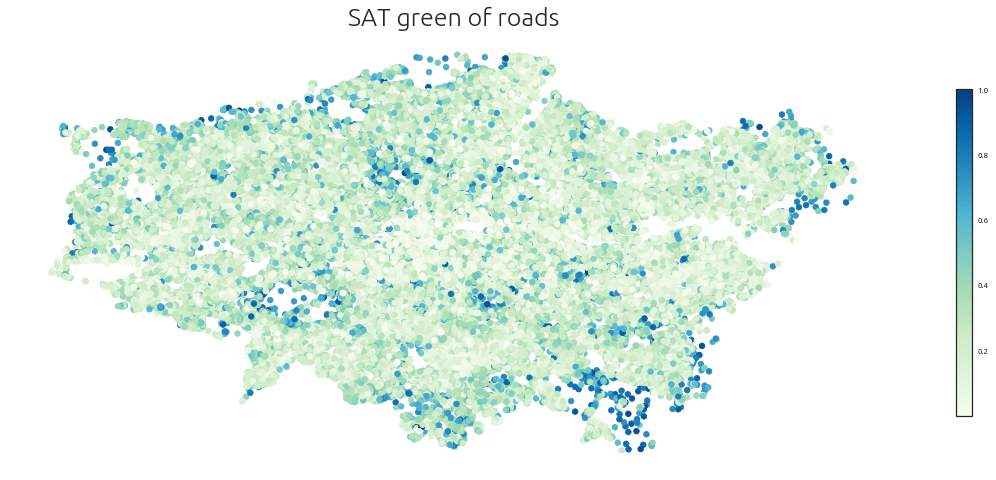

In [145]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('SAT green of roads', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=road_SAT_aggregated_gpd['sat_green_pct'].min(), vmax=road_SAT_aggregated_gpd['sat_green_pct'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
road_SAT_aggregated_gpd.plot(ax=ax,column='sat_green_pct', cmap='GnBu', linewidth=0.8)

In [146]:
joined_sat_road_wards = sjoin(wards_shape,road_SAT_aggregated_gpd,how='left')

joined_sat_road_wards= joined_sat_road_wards[joined_sat_road_wards['choice_scaled'].notna()]

joined_sat_road_wards.head(n=5)

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry,index_right,sat_green_pct,choice_scaled,osmid
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",160179.0,0.130282,5.702095,161636078
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",162429.0,0.159448,15.114575,161415777
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",24605.0,0.143261,19.890688,154532354
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",24611.0,0.173931,19.890688,154532353
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909...",159164.0,0.068174,0.000000,19822697


In [149]:
sat_ward_aggregated = {'GSS_CODE':[] , 'NAME' : [], 'geometry':[] , 'green_sat':[] }
for name , group in joined_sat_road_wards.groupby('GSS_CODE'):
    sat_ward_aggregated['GSS_CODE'].append(name)
    sat_ward_aggregated['geometry'].append(group.iloc[0]['geometry'])
    numerator = sum(group['sat_green_pct']*group['choice_scaled']*100.0)
    denom = sum(group['choice_scaled'])
    sat_ward_aggregated['green_sat'].append(numerator/denom)
    sat_ward_aggregated['NAME'].append(group.iloc[0]['NAME'])
sat_ward_aggregated_df = pd.DataFrame.from_dict(sat_ward_aggregated)
sat_ward_aggregated_gpd = gpd.GeoDataFrame(sat_ward_aggregated_df, geometry='geometry', crs={'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'})

In [150]:
sat_ward_aggregated_reproj = sat_ward_aggregated_gpd.to_crs({'init': 'epsg:27700'})

/work/sagarj/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


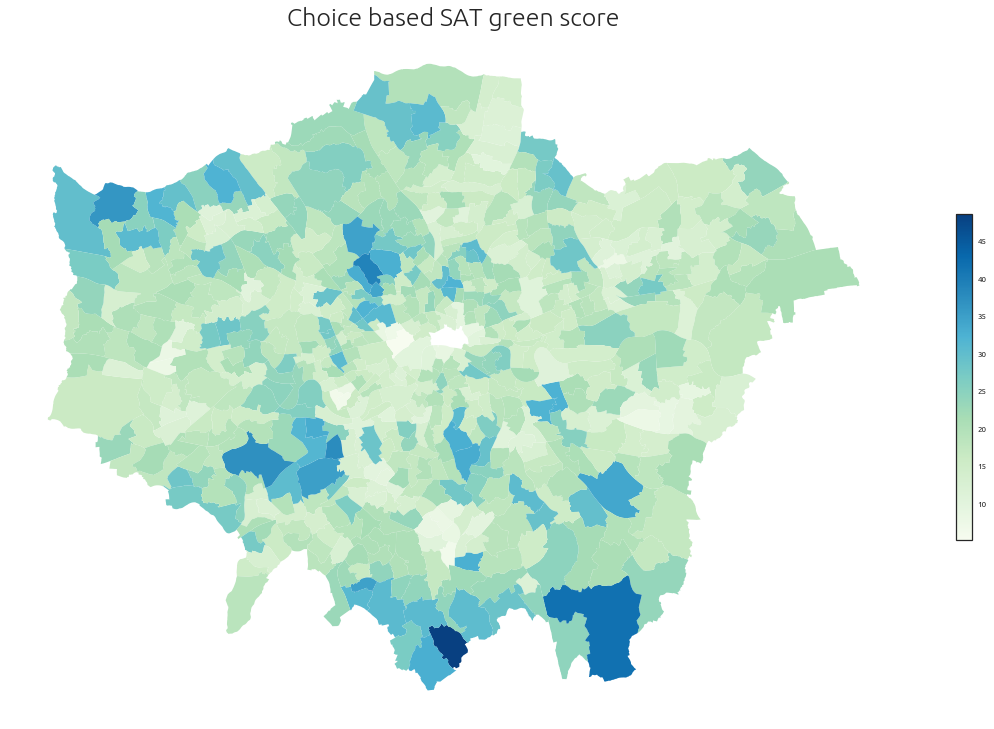

In [151]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
ax.axis('off')
ax.set_title('Choice based SAT green score', fontdict={'fontsize': '25', 'fontweight' : '5'})
sm = plt.cm.ScalarMappable(cmap='GnBu', norm=plt.Normalize(vmin=sat_ward_aggregated_reproj['green_sat'].min(), vmax=sat_ward_aggregated_reproj['green_sat'].max()))
#empty array for the data range
sm._A = []
#add the colorbar to the figure
cbar = fig.colorbar(sm,shrink=0.3)
sat_ward_aggregated_reproj.plot(ax=ax,column='green_sat', cmap='GnBu', linewidth=0.8)

In [152]:
# sat_ward_aggregated_reproj.to_file("Choice_Green_scores/London_choice_sat_green_score.shp")
# gsv_ward_aggregated_reproj.to_file("Choice_Green_scores/London_choice_gsv_green_score.shp")

In [153]:
sat_ward_aggregated_reproj.head(n=2)

,GSS_CODE,NAME,geometry,green_sat
0,E05000026,Abbey,"POLYGON ((544735.197 184076.498, 544726.597 18...",12.061087
1,E05000027,Alibon,"POLYGON ((547932.401 184916.597, 547944.801 18...",18.792613


In [154]:
gsv_ward_aggregated_reproj.head(n=2)

,GSS_CODE,NAME,geometry,green_gsv
0,E05000026,Abbey,"POLYGON ((544735.197 184076.498, 544726.597 18...",3.976812
1,E05000027,Alibon,"POLYGON ((547932.401 184916.597, 547944.801 18...",3.877607


In [155]:
green_sat_sub = sat_ward_aggregated_reproj[['GSS_CODE','green_sat']].copy()
overall_green = pd.merge(gsv_ward_aggregated_reproj,green_sat_sub, left_on='GSS_CODE' , right_on='GSS_CODE')

In [156]:
overall_green.head(n=2)

,GSS_CODE,NAME,geometry,green_gsv,green_sat
0,E05000026,Abbey,"POLYGON ((544735.197 184076.498, 544726.597 18...",3.976812,12.061087
1,E05000027,Alibon,"POLYGON ((547932.401 184916.597, 547944.801 18...",3.877607,18.792613


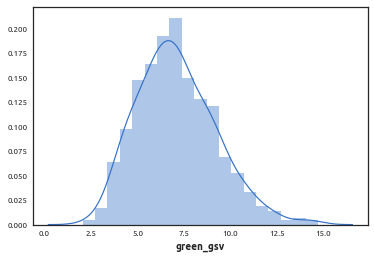

In [158]:
sns.distplot(overall_green['green_gsv'])

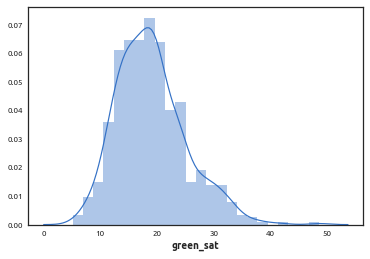

In [159]:
sns.distplot(overall_green['green_sat'])

In [160]:
# overall_green.to_file("Choice_Green_scores/London_choice_green_scores.shp")

In [169]:
import json
diseases  = json.load(open('../Data/health_data/timeSeries_data/prevalence_disease_timeseries.json','rb'))

In [170]:
def getDiseaase_frame(disease_dict , month ,diseaseName):
    if month in disease_dict:
        dictionary1 = disease_dict[month]['Ward_Prescriptions'][diseaseName]
        dictionary2 = disease_dict[month]['Ward_Prevalence'][diseaseName]
        data = {'GSS_CODE':[] , 'Prescriptions' : [] , 'Prevalence':[]}
        for k in dictionary2:
            data['GSS_CODE'].append(k)
            data['Prescriptions'].append(dictionary1[k])
            data['Prevalence'].append(dictionary2[k])
        dataframe = pd.DataFrame.from_dict(data)
        return dataframe

In [ ]:
depression = getDiseaase_frame(diseases, '201610' , 'depression')

In [161]:
data = pd.read_csv('Solo_living/All_data_aggregated_ward_level.csv')

In [163]:
data.head(n=2)
selected_ward_data= data[['GSS_CODE','WD17CD',
                          'depression_Prevalence','diabetes_Prevalence',
                          'avg_age','people_per_sq_km','All_jsa','Median 2012/13',
                          'IMD']].copy()

In [164]:
data_merge = pd.merge(overall_green,selected_ward_data, left_on='GSS_CODE' , right_on='GSS_CODE')

In [168]:
data_merge.corr()

,green_gsv,green_sat,depression_Prevalence,diabetes_Prevalence,avg_age,people_per_sq_km,All_jsa,Median 2012/13,IMD
green_gsv,1.000000,0.821334,0.319091,-0.253949,0.486249,-0.305664,0.037152,0.362360,0.279088
green_sat,0.821334,1.000000,0.205629,-0.180313,0.408597,-0.255065,-0.103659,0.308795,0.251357
depression_Prevalence,0.319091,0.205629,1.000000,-0.180723,0.263050,-0.015996,0.176807,0.167418,-0.043711
diabetes_Prevalence,-0.253949,-0.180313,-0.180723,1.000000,-0.136167,-0.056453,-0.348457,-0.528113,0.044542
avg_age,0.486249,0.408597,0.263050,-0.136167,1.000000,-0.440064,0.041922,0.516201,0.316825
people_per_sq_km,-0.305664,-0.255065,-0.015996,-0.056453,-0.440064,1.000000,0.218967,-0.059563,-0.804751
All_jsa,0.037152,-0.103659,0.176807,-0.348457,0.041922,0.218967,1.000000,0.446225,-0.310840
Median 2012/13,0.362360,0.308795,0.167418,-0.528113,0.516201,-0.059563,0.446225,1.000000,0.008258
IMD,0.279088,0.251357,-0.043711,0.044542,0.316825,-0.804751,-0.310840,0.008258,1.000000


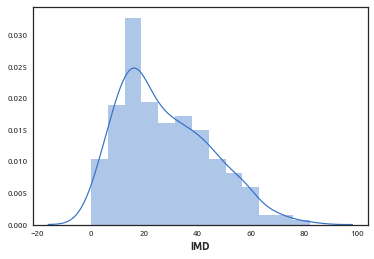

In [166]:
sns.distplot(data_merge['IMD'])